# Business Cycle Facts and Real Business Cycles Model

We will take a look at the data on business cycle fluctuations in the United States and then see if we can explain their behavior with the help of the basic RBC model.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

from pandas_datareader.data import DataReader

In [2]:
from matplotlib import rcParams

# Restore old behavior of rounding default axis ranges
rcParams['axes.autolimit_mode'] = 'round_numbers'
rcParams['axes.xmargin'] = 0
rcParams['axes.ymargin'] = 0

# Adjust tick placement
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
rcParams['xtick.top'] = True
rcParams['ytick.right'] = True

# Disable legend frame
rcParams['legend.frameon'] = False

Below we are downloading data from Federal Reserve Bank of St. Louis Economic Database (FRED) https://fred.stlouisfed.org/ and organizing them into three datasets.

The first dataset, `rec`, contains monthly data on whether in a given month the US economy was in a recession state (`1`) or not (`0`) - `USREC`

*Recession is a "business cycle contraction when there is a general decline in economic activity. Recessions generally occur when there is a widespread drop in spending (an adverse demand shock). This may be triggered by various events, such as a financial crisis, an external trade shock, an adverse supply shock, the bursting of an economic bubble, or a large-scale anthropogenic or natural disaster (e.g. a pandemic)."*

*In the United States, it is defined as "a significant decline in economic activity spread across the market, lasting more than a few months, normally visible in real GDP, real income, employment, industrial production, and wholesale-retail sales".*

*In the United Kingdom, it is defined as a negative economic growth for two consecutive quarters.*

The second dataset, `pop`, containts quarterly data on:
- total population in the US - `B230RC0Q173SBEA`
- civilian noninstitutional population of 16 years of age and older - `CNP16OV`

*Civilian noninstitutional population is defined as persons 16 years of age and older residing in the 50 states and 
the District of Columbia, who are not inmates of institutions (e.g., penal and mental facilities, homes for the aged), 
and who are not on active duty in the Armed Forces.*

The third dataset, `fred`, contains quarterly data on:

- nominal Gross Domestic Product in billions of current dollars - `GDP`
- nominal Personal Consumption Expenditures on Nondurable Goods - `PCND`
- nominal Personal Consumption Expenditures on Services - `PCESV`
- nominal Personal Consumption Expenditures on Durable Goods - `PCDG`
- nominal Fixed Private Investment - `FPI`
- Implicit Price Deflator for Gross Domestic Product - `GDPDEF`
- Nonfarm Business Sector: Current Dollar Output - `PRS85006053`
- total hours worked in the nonfarm business sector (index) - `HOANBS`
- nominal compensation per hour in the nonfarm business sector (index) - `COMPNFB`
- interest rate on 3-month treasury bill - `TB3MS`

In [3]:
start = '1945-01'
end   = '2021-06'

In [4]:
rec = DataReader('USREC', 'fred', start=start, end=end)
rec = rec.dropna()
rec.tail()



,USREC
DATE,
2021-02-01,0
2021-03-01,0
2021-04-01,0
2021-05-01,0
2021-06-01,0


In [5]:
pop = DataReader(['B230RC0Q173SBEA', 'CNP16OV'], 'fred', start=start, end=end)
pop = pop.dropna()
pop = pop.resample('QS').mean()
pop = pop.dropna()

pop.tail()

# data 单位为千

,B230RC0Q173SBEA,CNP16OV
DATE,,
2020-04-01,331692.0,259896.0
2020-07-01,331841.0,260373.0
2020-10-01,331978.0,260925.0
2021-01-01,331949.0,260851.0
2021-04-01,332021.0,261103.0


In [6]:
fred = DataReader(['GDP', 'PCND', 'PCESV', 'PCDG', 'FPI', 'GDPDEF',
                   'PRS85006053', 'HOANBS', 'COMPNFB', 'TB3MS'],
                  'fred', start=start, end=end)
fred = fred.dropna()
fred = fred.resample('QS').mean()
fred = fred.dropna()
fred.head()

# GDP单位为10亿

,GDP,PCND,PCESV,PCDG,FPI,GDPDEF,PRS85006053,HOANBS,COMPNFB,TB3MS
DATE,,,,,,,,,,
1947-01-01,243.164,74.872,60.567,20.722,35.359,11.952,1.474,45.842,3.746,0.38
1947-04-01,245.968,76.897,61.783,21.351,35.744,12.122,1.529,45.853,3.831,0.38
1947-07-01,249.585,78.649,63.124,21.770,37.827,12.326,1.554,45.979,3.945,0.66
1947-10-01,259.745,79.965,64.219,23.488,41.794,12.630,1.629,46.424,4.038,0.85
1948-01-01,265.742,81.546,65.279,23.547,43.576,12.731,1.675,46.719,4.134,0.97


In [7]:
fred.tail()

,GDP,PCND,PCESV,PCDG,FPI,GDPDEF,PRS85006053,HOANBS,COMPNFB,TB3MS
DATE,,,,,,,,,,
2020-04-01,19636.731,2857.752,8705.489,1486.525,3459.030,112.993,119.051,95.565,132.685,0.14
2020-07-01,21362.428,3100.433,9491.731,1796.537,3706.422,113.971,132.489,103.432,130.814,0.13
2020-10-01,21704.706,3098.301,9678.966,1808.769,3878.300,114.692,134.857,105.817,133.810,0.10
2021-01-01,22313.850,3274.375,9866.197,1990.912,4004.072,116.120,139.716,107.186,133.366,0.08
2021-04-01,23046.934,3416.432,10283.613,2113.500,4102.844,117.922,144.898,108.768,135.752,0.02


Since the population data are based on the population census, they exhibit periodic "jumps" that we will filter out. 
The time series are composed of three components: seasonal, cyclical, and trend. Assume that we have seasonally adjusted time series and we want to decompose time series into trend and cyclical components.<br> 
The Hodrick–Prescott filter (also known as Hodrick–Prescott decomposition) is a tool to remove the cyclical component of a time series from raw data.<br> 
Let $y_{t}$, for $t=1,2,...,T$ denote the logarithms of a time series variable. The series $y_{t}$, is made up of a trend component $\tau_{t}$, and a cyclical component $c_{t}$ such that $y_{t}=\tau_{t}+c_{t}$. Given an adequately chosen, positive value of $\lambda$ , the filter will decompose $y_{t}$ into $\tau_{t}$ and $c_{t}$.<br> 
$\lambda$ is the Hodrick-Prescott smoothing parameter. A value of $1600$ is suggested for quarterly data. Ravn and Uhlig suggest using a value of $6.25$ for annual data and $129600$ for monthly data.

In [8]:

pop_hp_cycle = pd.DataFrame()
pop_hp_trend = pd.DataFrame()

for col in pop.columns:
    # HP Filter（lambda）uses log
    pop_hp_cycle[col], pop_hp_trend[col] = sm.tsa.filters.hpfilter(np.log(pop[col]), lamb=1600)

   
pop_smooth = np.exp(pop_hp_trend)

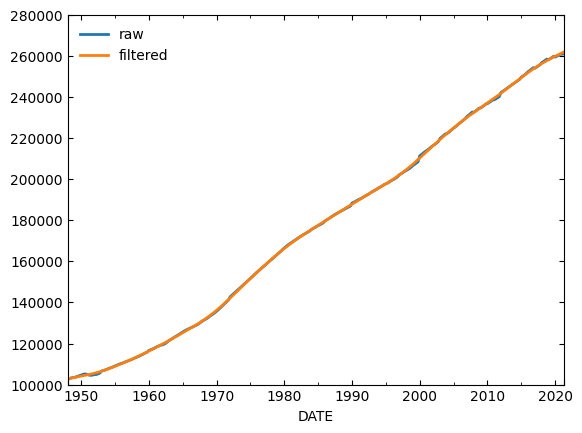

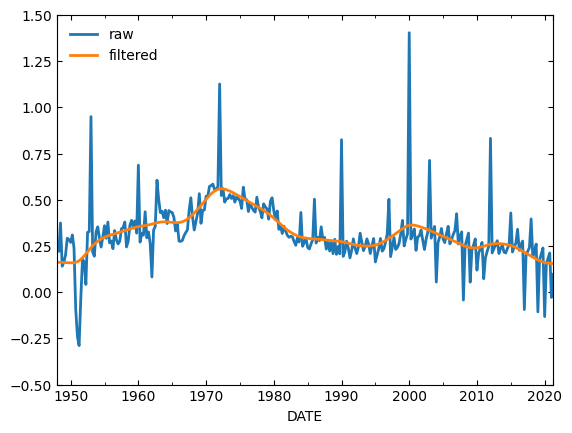

In [9]:
fig, ax = plt.subplots()

pop['CNP16OV'].to_period('D').plot(ax=ax, lw=2)
pop_smooth['CNP16OV'].to_period('D').plot(ax=ax, lw=2)
plt.legend(['raw', 'filtered'])
plt.show()

fig, ax = plt.subplots()

(100*pop['CNP16OV'].pct_change()).to_period('D').plot(ax=ax, lw=2)
(100*pop_smooth['CNP16OV'].pct_change()).to_period('D').plot(ax=ax, lw=2)
plt.legend(['raw', 'filtered'], loc='upper left')
plt.show()

Below we are constructing the series that will correspond to model objects. All variables will be expressed in logarithms:
- `Output` is real GDP per person (aged 16 and over)
- `Consumption` is the real sum of expenditures on nondurable goods and services per person
- `Investment` is the real sum of expenditures on durable goods and fixed private investment per person
- `Capital` will contain real capital stock per person (to be constructed later)
- `Hours` is hours worked per person, corrected for the difference between the entire economy and the nonfarm business sector
- `Wages` is real compensation per hour worked
- `Interest Rate` is the real quarterly return on the 3 month treasury bill
- `TFP` will contain Total Factor Productivity series (to be constructed later)
- `Productivity` is the real output per hour worked in the nonfarm business sector
- `Price Level` is the GDP implicit price deflator

In [10]:
dta = pd.DataFrame()

dta['Output'] = np.log(fred['GDP']*10**9/fred['GDPDEF']*100
                       /(pop_smooth['CNP16OV']*10**3))

dta['Consumption'] = np.log((fred['PCND']+fred['PCESV'])*10**9/fred['GDPDEF']*100
                            /(pop_smooth['CNP16OV']*10**3))

dta['Investment'] = np.log((fred['PCDG']+fred['FPI'])*10**9/fred['GDPDEF']*100
                           /(pop_smooth['CNP16OV']*10**3))

dta['Capital'] = 0*dta['Output']

dta['Hours'] = np.log(fred['HOANBS']*100*fred['GDP']/np.mean(fred['GDP']['2010-01':'2010-10'])
                      /fred['PRS85006053']/pop_smooth['CNP16OV'])

dta['Wages'] = np.log(fred['COMPNFB']/fred['GDPDEF']*100)

dta['Interest Rate'] = np.log( (1+fred['TB3MS']/100)**(1/4)/(1+fred['GDPDEF'].pct_change()) )

dta['TFP'] = 0*dta['Output']

dta['Productivity'] = np.log(fred['PRS85006053']/fred['GDPDEF']*100)-dta['Hours']

dta['Price Level'] = np.log(fred['GDPDEF'])

dta = dta.dropna()

dta.head()

,Output,Consumption,Investment,Capital,Hours,Wages,Interest Rate,TFP,Productivity,Price Level
DATE,,,,,,,,,,
1948-01-01,9.918737,9.325452,8.542738,0.0,-7.643461,3.480376,-0.005552,0.0,10.220404,2.544040
1948-04-01,9.933566,9.337137,8.552457,0.0,-7.633761,3.484678,-0.006427,0.0,10.215428,2.552955
1948-07-01,9.937623,9.328240,8.563334,0.0,-7.631628,3.486641,-0.015871,0.0,10.222239,2.571314
1948-10-01,9.937142,9.331203,8.553932,0.0,-7.646866,3.493364,-0.000268,0.0,10.242983,2.574366
1949-01-01,9.921683,9.331265,8.512283,0.0,-7.670911,3.504487,0.008256,0.0,10.258647,2.569018


In [11]:
dta.tail()

,Output,Consumption,Investment,Capital,Hours,Wages,Interest Rate,TFP,Productivity,Price Level
DATE,,,,,,,,,,
2020-04-01,11.108931,10.579361,9.730019,0.0,-7.818064,4.765822,0.004104,0.0,12.475460,4.727326
2020-07-01,11.182980,10.654421,9.826632,0.0,-7.763237,4.743003,-0.008293,0.0,12.518962,4.735944
2020-10-01,11.191014,10.661152,9.851680,0.0,-7.743815,4.759341,-0.006056,0.0,12.510950,4.742250
2021-01-01,11.204768,10.675265,9.890484,0.0,-7.740229,4.743643,-0.012174,0.0,12.530387,4.754624
2021-04-01,11.220146,10.700013,9.909795,0.0,-7.731219,4.745976,-0.015349,0.0,12.542395,4.770023


Below we will estimate the capital stock based on the Perpetual Inventory Method (PIM) that simply applies the capital accumulation equation:

\begin{align}
K_{t+1} = I_{t} + \left( 1-\delta \right) K_{t}
\end{align}

We need to "start" this procedure from a certain level of initial capital stock, $K_{0}$, which is below calculated basing on the investment trend in the beginning of the sample.

                            OLS Regression Results                            
Dep. Variable:                  LnInv   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     8819.
Date:                Mon, 16 Jan 2023   Prob (F-statistic):          2.38e-222
Time:                        17:07:46   Log-Likelihood:                 201.58
No. Observations:                 298   AIC:                            -399.2
Df Residuals:                     296   BIC:                            -391.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.9605      0.014    347.729      0.0

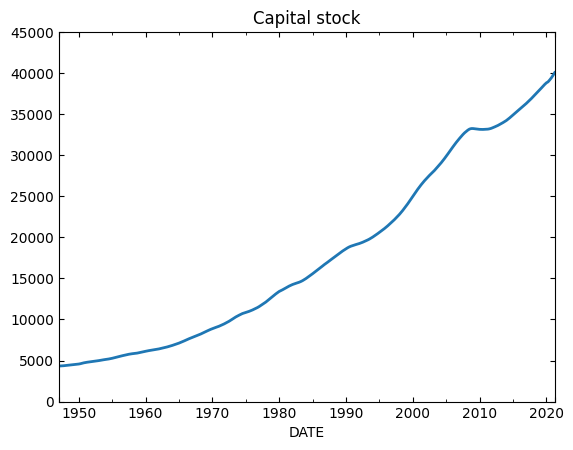

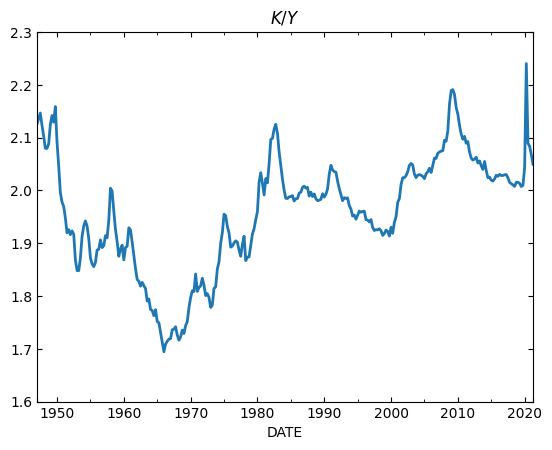

In [12]:
# Estimate Capital series using PIM
temp = pd.DataFrame()

temp['Inv'] = (fred['PCDG']+fred['FPI'])/fred['GDPDEF']*100/4
temp['LnInv'] = np.log(temp['Inv'])
temp['t'] = np.arange(len(temp['Inv']))

trend = smf.ols(formula='LnInv ~ t', data=temp).fit()
# weight is trend
intercept, slope = trend.params
print(trend.summary())


delta = 0.025
K = np.zeros(len(temp['LnInv']))
K_init = np.exp(intercept-slope)/(slope+delta)

K[0] = (1-delta)*K_init+temp['Inv'][0]
for i in range(1,len(temp['Inv'])):
    K[i] = (1-delta)*K[i-1]+temp['Inv'][i]
temp['Cap'] = K

temp['Cap'].to_period('D').plot(lw=2)
plt.title('Capital stock')
plt.show()

(temp['Cap']/(fred['GDP']/fred['GDPDEF']*100)).to_period('D').plot(lw=2)
plt.title('$K / Y$')
plt.show()

We recover the constructed time series for capital and construct the TFP measure from the production function:

\begin{align}
Y_{t} &= K_{t}^{\alpha} \left( A_{t} L_{t} \right)^{1-\alpha} \\
Y_{t} &= TFP_{t} \cdot K_{t}^{\alpha} L_{t}^{1-\alpha} \\
TFP_{t} &= Y_{t} / \left( K_{t}^{\alpha} L_{t}^{1-\alpha} \right) \\
\log TFP_{t} &= \log Y_{t} - \alpha \log K_{t} - \left(1-\alpha \right) \log L_{t}
\end{align}

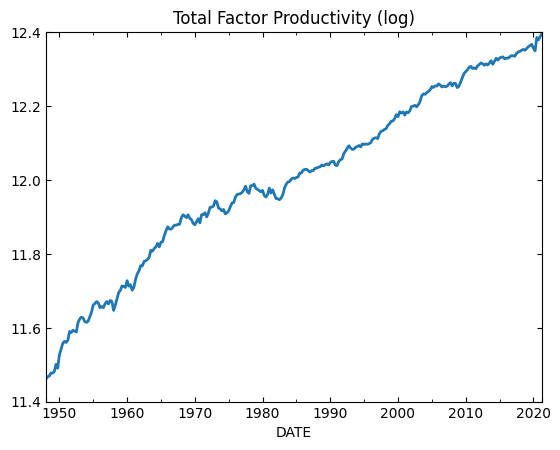

In [13]:
dta['Capital'] = np.log(temp['Cap']*10**9/(pop_smooth['CNP16OV']*10**3))

α = 1/3
dta['TFP'] = dta['Output']-α*dta['Capital']-(1-α)*dta['Hours']
dta['TFP'].to_period('D').plot(lw=2)
plt.title('Total Factor Productivity (log)')
plt.show()

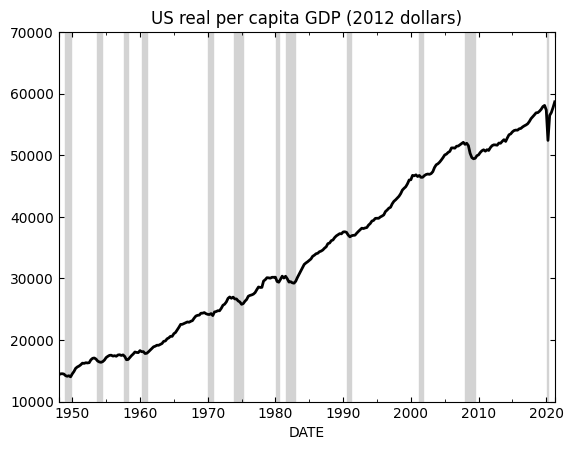

In [14]:
RGDP_pc = (fred['GDP']*10**9/fred['GDPDEF']*100/(pop_smooth['B230RC0Q173SBEA']*10**3)).dropna()

fig, ax = plt.subplots()

RGDP_pc.to_period('D').plot(ax=ax, lw=2, style='k-')

ax.set_ylim(10000, 70000)
ylim = ax.get_ylim()

ax.fill_between(rec.index, ylim[0], ylim[1], rec['USREC'], facecolor='lightgrey', edgecolor='lightgrey')

plt.title('US real per capita GDP (2012 dollars)')
plt.show()

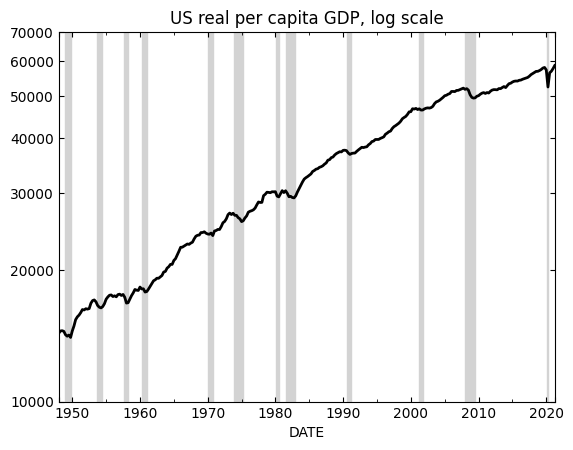

In [15]:
fig, ax = plt.subplots()

np.log(RGDP_pc).to_period('D').plot(ax=ax, lw=2, style='k-')

ticks = [10000, 20000, 30000, 40000, 50000, 60000, 70000]
ax.set_yticks(np.log(ticks))
ax.set_yticklabels(ticks)

ax.set_ylim(np.log(ticks[0]), np.log(ticks[-1]))

ylim = ax.get_ylim()
ax.set_ylim(ylim)

ax.fill_between(rec.index, ylim[0], ylim[1], rec['USREC'], facecolor='lightgrey', edgecolor='lightgrey')

plt.title('US real per capita GDP, log scale')
plt.show()

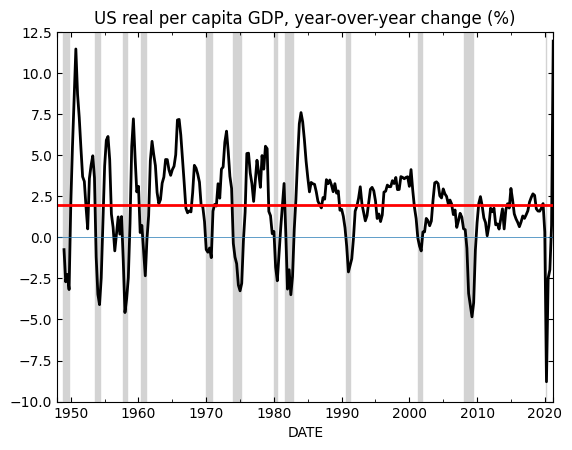

Average growth rate (%) = 1.96


In [16]:
fig, ax = plt.subplots()

(100*RGDP_pc.pct_change(4)).to_period('D').plot(ax=ax, lw=2, style='k-')

avg = np.mean(100*RGDP_pc.to_period('D').pct_change(4))

# ax.set_ylim(-6, 12)
ylim = ax.get_ylim()

ax.hlines(avg, dta.index[0], dta.index[-1], color='r', linewidth=2)
ax.hlines(0, dta.index[0], dta.index[-1], linewidth=0.5)

ax.fill_between(rec.index, ylim[0], ylim[1], rec['USREC'], facecolor='lightgrey', edgecolor='lightgrey')

plt.title('US real per capita GDP, year-over-year change (%)')
plt.show()

print('Average growth rate (%) =', round(avg,2))

In [17]:
gdp_lin_cycle, gdp_lin_trend = sm.tsa.filters.hpfilter(np.log(RGDP_pc), lamb=1e9)
gdp_hp_cycle, gdp_hp_trend = sm.tsa.filters.hpfilter(np.log(RGDP_pc), lamb=1600)
gdp_cf_cycle, gdp_cf_trend = sm.tsa.filters.cffilter(np.log(RGDP_pc), low=6, high=32)#linear

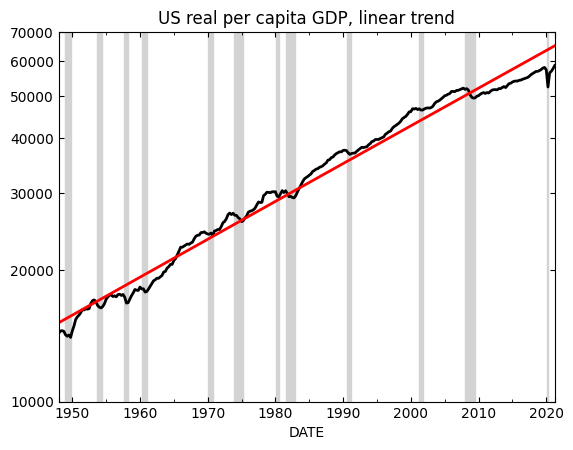

In [18]:
fig, ax = plt.subplots()

np.log(RGDP_pc).to_period('D').plot(ax=ax, lw=2, style='k-')
gdp_lin_trend.plot(ax=ax, lw=2, style='r-')

ticks = [10000, 20000, 30000, 40000, 50000, 60000, 70000]
ax.set_yticks(np.log(ticks))
ax.set_yticklabels(ticks)

ax.set_ylim(np.log(ticks[0]), np.log(ticks[-1]))

ylim = ax.get_ylim()
ax.set_ylim(ylim)

ax.fill_between(rec.index, ylim[0], ylim[1], rec['USREC'], facecolor='lightgrey', edgecolor='lightgrey')

plt.title('US real per capita GDP, linear trend')
plt.show()

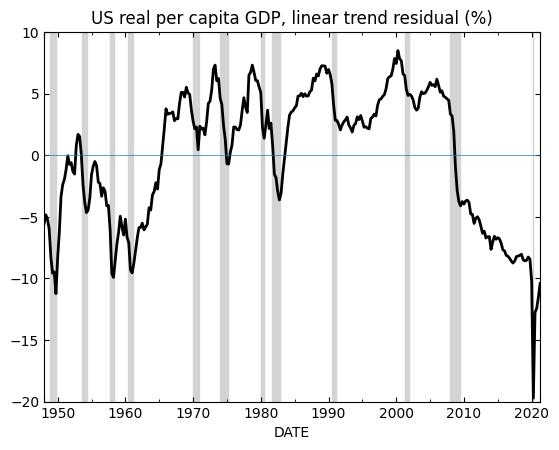

In [19]:
fig, ax = plt.subplots()

(100*gdp_lin_cycle).to_period('D').plot(ax=ax, lw=2, style='k-')
ax.hlines(0, dta.index[0], dta.index[-1], linewidth=0.5)

ylim = ax.get_ylim()
ax.set_ylim(ylim)

ax.fill_between(rec.index, ylim[0], ylim[1], rec['USREC'], facecolor='lightgrey', edgecolor='lightgrey')

plt.title('US real per capita GDP, linear trend residual (%)')
plt.show()

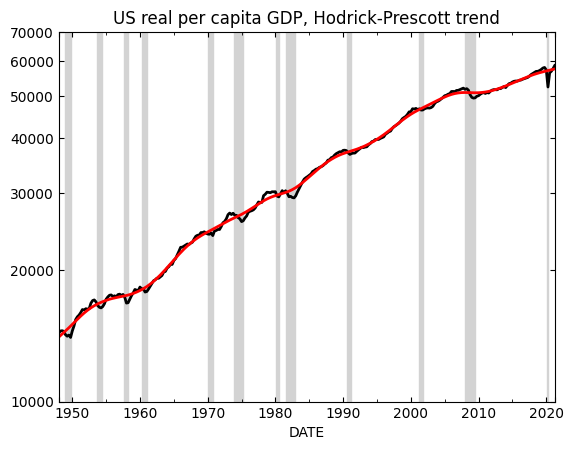

In [20]:
fig, ax = plt.subplots()

np.log(RGDP_pc).to_period('D').plot(ax=ax, lw=2, style='k-')
gdp_hp_trend.plot(ax=ax, lw=2, style='r-')

ticks = [10000, 20000, 30000, 40000, 50000, 60000, 70000]
ax.set_yticks(np.log(ticks))
ax.set_yticklabels(ticks)

ax.set_ylim(np.log(ticks[0]), np.log(ticks[-1]))

ylim = ax.get_ylim()
ax.set_ylim(ylim)

ax.fill_between(rec.index, ylim[0], ylim[1], rec['USREC'], facecolor='lightgrey', edgecolor='lightgrey')

plt.title('US real per capita GDP, Hodrick-Prescott trend')
plt.show()

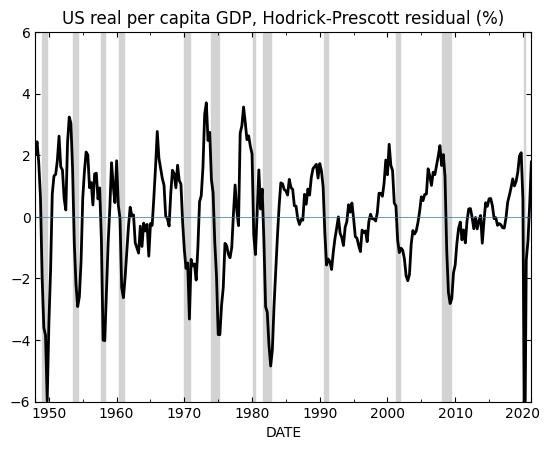

In [21]:
fig, ax = plt.subplots()

(100*gdp_hp_cycle.to_period('D')).plot(ax=ax, lw=2, style='k-')
ax.hlines(0, dta.index[0], dta.index[-1], linewidth=0.5)

ax.set_ylim(-6, 6)
ylim = ax.get_ylim()

ax.fill_between(rec.index, ylim[0], ylim[1], rec['USREC'], facecolor='lightgrey', edgecolor='lightgrey')

plt.title('US real per capita GDP, Hodrick-Prescott residual (%)')
plt.show()

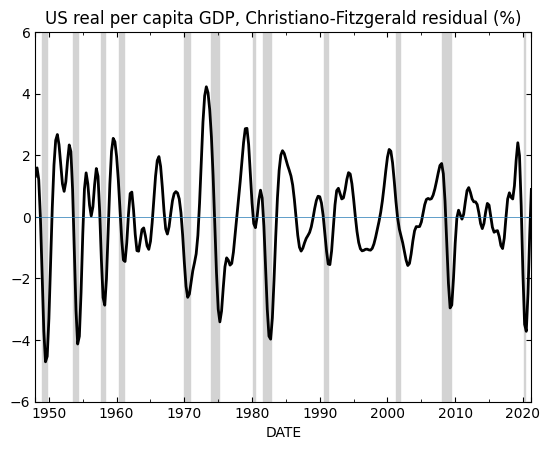

In [22]:
fig, ax = plt.subplots()

(100*gdp_cf_cycle).to_period('D').plot(ax=ax, lw=2, style='k-')
ax.hlines(0, dta.index[0], dta.index[-1], linewidth=0.5)

ylim = ax.get_ylim()

ax.fill_between(rec.index, ylim[0], ylim[1], rec['USREC'], facecolor='lightgrey', edgecolor='lightgrey')

plt.title('US real per capita GDP, Christiano-Fitzgerald residual (%)')
plt.show()

In [23]:
np.corrcoef(gdp_hp_cycle, gdp_cf_cycle)

array([[1.        , 0.86730928],
       [0.86730928, 1.        ]])

In [24]:
hp_cycles = pd.DataFrame()
hp_trend = pd.DataFrame()

cf_cycles = pd.DataFrame()
cf_trend = pd.DataFrame()

for col in dta.columns:
    hp_cycles[col], hp_trend[col] = sm.tsa.filters.hpfilter((100*dta[col]).dropna(), lamb=1600)
    cf_cycles[col], cf_trend[col] = sm.tsa.filters.cffilter((100*dta[col]).dropna(), low=6, high=32)

In [25]:
print('Standard Deviations')
print(hp_cycles.std())

print('\nAutocorrelations')
a = list(dta.columns.values)
for i in range(len(a)):
    print(dta.columns.values[i], '  \t\t', hp_cycles[dta.columns.values[i]].autocorr())

print('')
print('Correlations')
print(hp_cycles.corr(method='pearson'))

Standard Deviations
Output           1.666735
Consumption      1.080949
Investment       4.479965
Capital          0.550539
Hours            1.735953
Wages            0.913569
Interest Rate    0.394122
TFP              0.993833
Productivity     1.304874
Price Level      0.886329
dtype: float64

Autocorrelations
Output   		 0.778137121743013
Consumption   		 0.6163616300135246
Investment   		 0.8588034720688059
Capital   		 0.9650896102865074
Hours   		 0.8106529412268736
Wages   		 0.642377521172503
Interest Rate   		 0.4152820214721162
TFP   		 0.6877372496327769
Productivity   		 0.6378003934428979
Price Level   		 0.9051281279454557

Correlations
                 Output  Consumption  Investment   Capital     Hours  \
Output         1.000000     0.755690    0.770762  0.362926  0.824746   
Consumption    0.755690     1.000000    0.539919  0.327989  0.729066   
Investment     0.770762     0.539919    1.000000  0.245384  0.607038   
Capital        0.362926     0.327989    0.245384  1.00

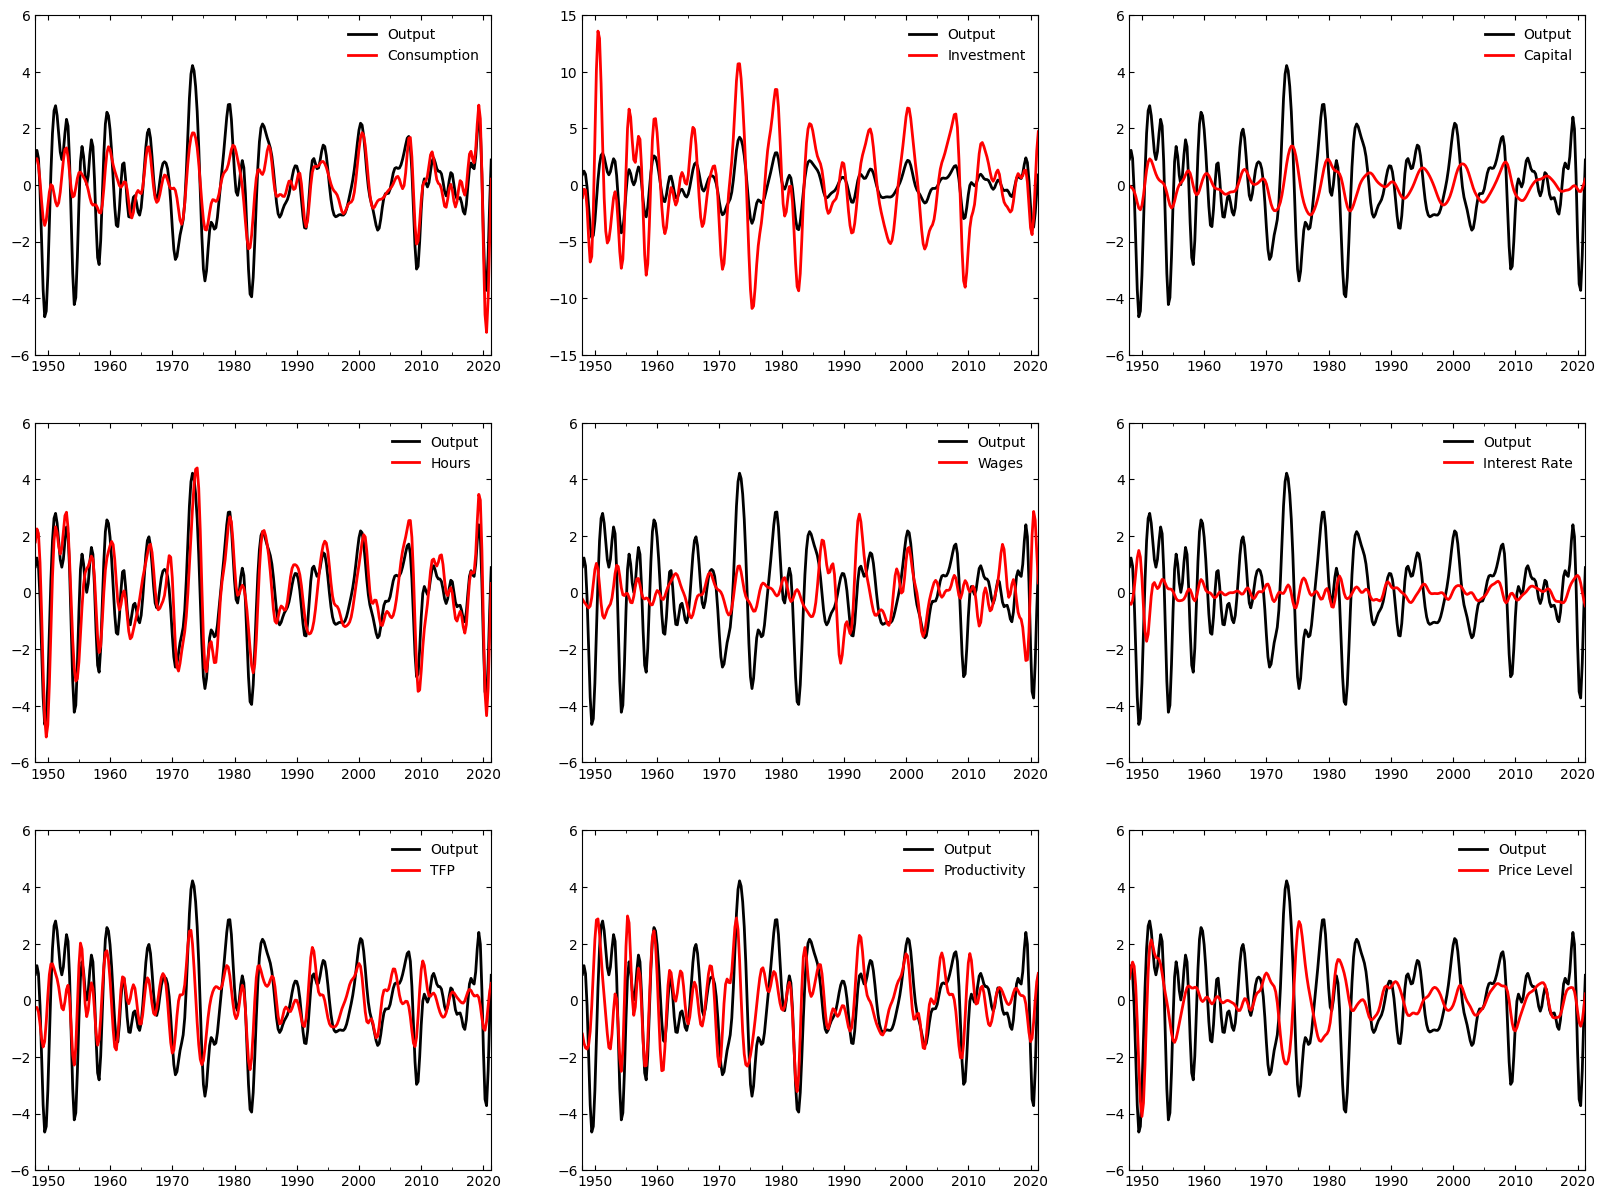

In [26]:
cf_cycles['Investment / 4'] = cf_cycles['Investment'] / 4

fig, axs = plt.subplots(3, 3, figsize=(20, 15), sharex=False, sharey=False)

cf_cycles[['Output','Consumption']].to_period('D').plot(ax=axs[0, 0], style=['k','r'], lw=2)

cf_cycles[['Output','Investment']].to_period('D').plot(ax=axs[0, 1], style=['k','r'], lw=2)

cf_cycles[['Output','Capital']].to_period('D').plot(ax=axs[0, 2], style=['k','r'], lw=2)

cf_cycles[['Output','Hours']].to_period('D').plot(ax=axs[1, 0], style=['k','r'], lw=2)

cf_cycles[['Output','Wages']].to_period('D').plot(ax=axs[1, 1], style=['k','r'], lw=2)

cf_cycles[['Output','Interest Rate']].to_period('D').plot(ax=axs[1, 2], style=['k','r'], lw=2)

cf_cycles[['Output','TFP']].to_period('D').plot(ax=axs[2, 0], style=['k','r'], lw=2)

cf_cycles[['Output','Productivity']].to_period('D').plot(ax=axs[2, 1], style=['k','r'], lw=2)

cf_cycles[['Output','Price Level']].to_period('D').plot(ax=axs[2, 2], style=['k','r'], lw=2)

for ax_a in axs:
    for ax in ax_a:
        ax.set_xlabel('')

plt.show()

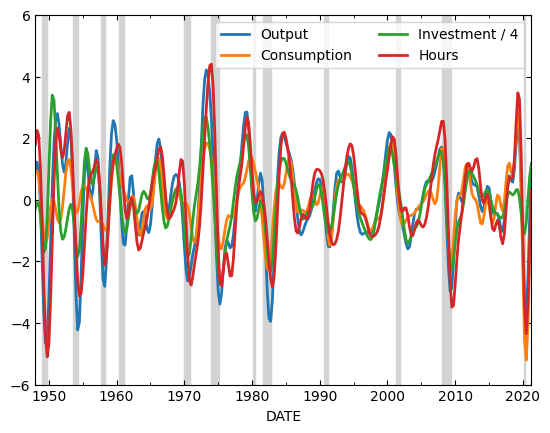

In [27]:
fig, ax = plt.subplots()

cf_cycles[['Output','Consumption','Investment / 4','Hours']].to_period('D').plot(ax=ax, lw=2)

ylim = ax.get_ylim()

ax.fill_between(rec.index, ylim[0], ylim[1], rec['USREC'], facecolor='lightgrey', edgecolor='lightgrey')

plt.legend(ncol=2, frameon=True)
plt.show()

In [28]:
dta['t'] = np.arange(len(dta['TFP']))
trend_TFP = smf.ols(formula='TFP ~ t', data=dta).fit()
dta['TFP_resid'] = trend_TFP.resid#?
intercept_TFP, slope_TFP = trend_TFP.params
print(trend_TFP.summary())

                            OLS Regression Results                            
Dep. Variable:                    TFP   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                 1.116e+04
Date:                Mon, 16 Jan 2023   Prob (F-statistic):          1.12e-234
Time:                        17:09:58   Log-Likelihood:                 540.81
No. Observations:                 294   AIC:                            -1078.
Df Residuals:                     292   BIC:                            -1070.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.5902      0.004   2582.161      0.0

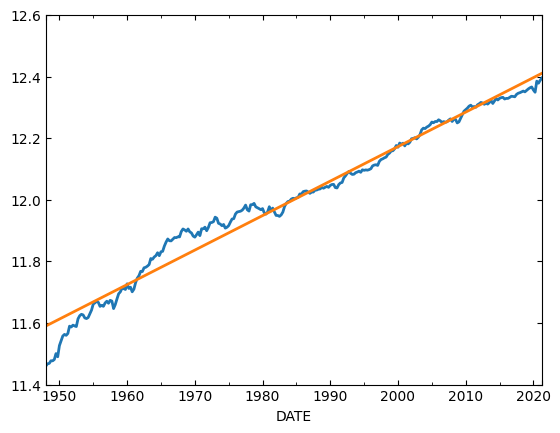

In [29]:
dta['TFP'].to_period('D').plot(lw=2)
(intercept_TFP + slope_TFP*dta['t']).plot(lw=2)
plt.show()

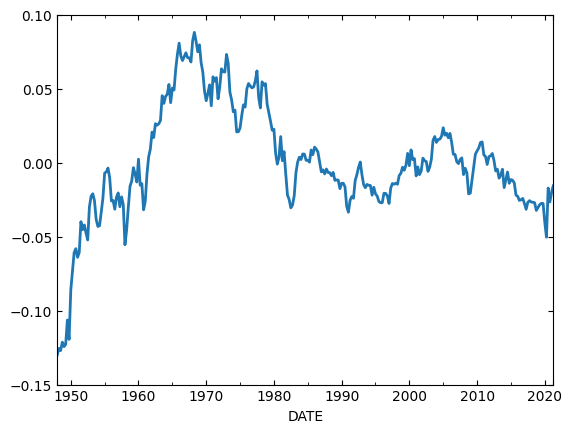

In [30]:
dta['TFP_resid'].to_period('D').plot(lw=2) # 残差即线性回归的epsino
plt.show()

In [31]:
resid_TFP = smf.ols(formula='TFP_resid ~ TFP_resid.shift() -1', data=dta).fit()
print(resid_TFP.summary())

print('')
print('TFP residual autocorrelation    =', resid_TFP.params[0])
print('TFP residual standard deviation =', resid_TFP.resid.std())

                                 OLS Regression Results                                
Dep. Variable:              TFP_resid   R-squared (uncentered):                   0.955
Model:                            OLS   Adj. R-squared (uncentered):              0.955
Method:                 Least Squares   F-statistic:                              6257.
Date:                Mon, 16 Jan 2023   Prob (F-statistic):                   2.91e-199
Time:                        17:10:04   Log-Likelihood:                          999.93
No. Observations:                 293   AIC:                                     -1998.
Df Residuals:                     292   BIC:                                     -1994.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

In [32]:
rho_z    = resid_TFP.params[0]
stderr_z = resid_TFP.resid.std()

#  Real Business Cycles (RBC) models 

Dynamic Stochastic General Equilibrium (DSGE) models aimto replicate business cycle behavior of real-world economies

– Dynamic: forward-looking behavior of agents

– Stochastic: the economy is subject to shocks

– GE: what happens in one market influences other markets\smallskip

We can generate quantitative predictions on short-term movements of macro variables and compare them with the data\medskip

We use those models to

– Simulate counterfactual scenarios

– Explain past developments (historical decomposition)

– Construct forecasts (conditional and uncoditional)

– Perform policy experiments\smallskip

## The RBC Model
Ramsey model with endogenous labor supplyand stochastic “technology” shocks<br><br>
Closed economy with no government<br><br>
Perfect competition<br><br>
Single final good with price normalized to 1 – all other prices are real<br><br>
Two groups of representative agents

– Households

– Firms\smallskip

Rational expectations – agents make no systematic forecast errors

### Household

A representative household solves the expected utility maximization problem:

\begin{align}
\max_{c_{t},a_{t+1}}\quad & U_{t}=E_{t}\left[\sum_{t=0}^{\infty}\beta^{t}\left(\log c_{t}+\phi \log \left(1-h_{t}\right)\right)\right]\\
\text{subject to}\quad & c_{t}+a_{t+1}=\left(1+r_{t}\right)a_{t}+w_{t}h_{t}+d_{t}
\end{align}

where:

$\beta$	- discount factor<br>
$c$	- per capita consumption<br>
$\phi$	- relative preference for leisure<br>
$h$	- per capita hours (as fraction of total available time)<br>
$a$	- per capita assets (physical capital)<br>
$r$	- real interest rate<br>
$w$	- real wage per hour<br>
$d$	- per capita dividends

Write down the Lagrangian:
\begin{align}
\mathcal{L}	=\sum_{t=0}^{\infty}\beta^{t}\mathrm{E}_{t}\left[\ln c_{t}+\phi\ln\left(1-h_{t}\right)\right]+\sum_{t=0}^{\infty}\beta^{t}\mathrm{E}_{t}\left[\lambda_{t}\left[\left(1+r_{t}\right)a_{t}+w_{t}h_{t}+d_{t}-a_{t+1}-c_{t}\right]\right]
\end{align}

FOCs:
\begin{align}
\frac{\partial\mathcal{L}}{\partial c_{t}} &	=  \mathrm{E}_{t}\left[\frac{1}{c_{t}}\right]-\mathrm{E}_{t}\left[\lambda_{t}\right]=0\to\quad & \lambda_{t} & =\frac{1}{c_{t}}\\
\frac{\partial\mathcal{L}}{\partial h_{t}} &	=  \mathrm{E}_{t}\left[-\frac{\phi}{1-h_{t}}\right]+\mathrm{E}_{t}\left[\lambda_{t}w_{t}\right]=0\to\quad & \lambda_{t} & =\frac{\phi}{w_{t}\left(1-h_{t}\right)}\\
\frac{\partial\mathcal{L}}{\partial a_{t+1}} &	=  - \mathrm{E}_{t}\left[\lambda_{t}\right]+\beta\mathrm{E}_{t}\left[\lambda_{t+1}\left(1+r_{t+1}\right)\right]=0
	\to\quad & \lambda_{t} & =\beta\mathrm{E}_{t}\left[\lambda_{t+1}\left(1+r_{t+1}\right)\right]
\end{align}

Optimality conditions:
\begin{align}
\text{Intertemporal condition }\left(c+a\right)	& :	\frac{1}{c_{t}}=\beta\mathrm{E}_{t}\left[\frac{1}{c_{t+1}}\left(1+r_{t+1}\right)\right]\\
\text{Intratemporal condition }\left(c+h\right)	& :	\frac{1}{c_{t}} =\frac{\phi}{w_{t}\left(1-h_{t}\right)}\to\quad h_{t}=1-\phi\frac{c_{t}}{w_{t}}
\end{align}


### Firms
A representative firm solves profit (dividend) maximization problem:

\begin{align}
\max\quad&d_{t}=y_{t}-r_{t}^{k}k_{t}-w_{t}h_{t}\\\text{subject to}\quad&y_{t}=z_{t}k_{t}^{\alpha}h_{t}^{1-\alpha}\\&r_{t}^{k}=r_{t}+\delta
\end{align}

where:

$d$	- per capita dividends<br>
$y$	- per capita output<br>
$r^{k}$	- capital rental rate<br>
$k$	- per capita physical capital stock<br>
$w$	- real wage per hour<br>
$h$	- per capita hours (as fraction of total available time)<br>
$z$	- stochastic total factor productivity (TFP) level<br>
$\alpha$	- physical capital share in output<br>
$r$	- real interest rate<br>
$\delta$	- physical capital depreciation rate<br>

Rewritten problem:

\begin{align}
\max\quad d_{t}=z_{t}k_{t}^{\alpha}h_{t}^{1-\alpha}-\left(r_{t}+\delta\right)k_{t}-w_{t}h_{t}
\end{align}

First Order Conditions:
\begin{align}
\frac{\partial d_{t}}{\partial k_{t}}	=\alpha z_{t}k_{t}^{\alpha-1}h_{t}^{1-\alpha}-\left(r_{t}+\delta\right)=0\quad\,\to\quad r_{t}=\alpha z_{t}k_{t}^{\alpha-1}h_{t}^{1-\alpha}-\delta\\
\frac{\partial d_{t}}{\partial h_{t}}	=\left(1-\alpha\right)z_{t}k_{t}^{\alpha}h_{t}^{-\alpha}-w_{t}=0\quad\quad\to\quad w_{t}=\left(1-\alpha\right)z_{t}k_{t}^{\alpha}h_{t}^{-\alpha}  marginal productivie
\end{align}

Alternative expressions for factor prices:
\begin{align}
r_{t}	=\alpha\frac{y_{t}}{k_{t}}-\delta\\
w_{t}	=\left(1-\alpha\right)\frac{y_{t}}{h_{t}}
\end{align}

Due to perfect competition and CRS economic profits equal zero:
\begin{align}
d_{t}=y_{t}-r_{t}^{k}k_{t}-w_{t}h_{t}=y_{t}-\alpha\frac{y_{t}}{k_{t}}\cdot k_{t}-\left(1-\alpha\right)\frac{y_{t}}{h_{t}}\cdot h_{t}=0
\end{align}


### General Equilibrium
Capital market clears:
\begin{align}
a_{t}=k_{t}
\end{align}

Households' budget constraint can be written as resource constraint:
\begin{align}
a_{t+1}+c_{t}	& =	\left(1+r_{t}\right)a_{t}+w_{t}h_{t}+d_{t}\\
k_{t+1}+c_{t}	& =	\left(1+\alpha\frac{y_{t}}{k_{t}}-\delta\right)k_{t}+\left(1-\alpha\right)\frac{y_{t}}{h_{t}}\cdot h_{t}+0\\
k_{t+1}+c_{t}	& =	\alpha y_{t}+\left(1-\delta\right)k_{t}+\left(1-\alpha\right)y_{t}\\
k_{t+1}+c_{t}	& =	y_{t}+\left(1-\delta\right)k_{t}
\end{align}

If we define investment as:
\begin{align}
i_{t}=k_{t+1}-\left(1-\delta\right)k_{t}
\end{align}

We can rewrite the resource constraint as the GDP accounting equation:
\begin{align}
y_{t}=c_{t}+i_{t}
\end{align}


### TFP Process
TFP evolves according to an AR(1) process:
\begin{align}
z_{t}=\left(1-\rho_{z}\right)+\rho_{z}\cdot z_{t-1}+\varepsilon_{t}
\end{align}

where $\rho_{z}<1$ regulates shock persistence and $\varepsilon$ is zero-mean white noise

It is often assumed that 
\begin{align}
\varepsilon\sim\mathcal{N}\left(0,\sigma_{z}^{2}\right)
\end{align}

In the absence of shocks
\begin{align}
z\to1\
\end{align}

### Full set of equilibrium conditions
System of 8 equations and 8 unknowns:
$\left\{ y,c,i,k,h,w,r,z\right\}$

\begin{align}
\text{Euler equation}	& :	\frac{1}{c_{t}}=\beta\mathrm{E}_{t}\left[\frac{1}{c_{t+1}}\left(1+r_{t+1}\right)\right]\\
\text{Consumption-hours choice}	& :	h_{t}=1-\phi\frac{c_{t}}{w_{t}}\\
\text{Production function}	& :	y_{t}=z_{t}k_{t}^{\alpha}h_{t}^{1-\alpha}\\
\text{Real interest rate}	& :	r_{t}=\alpha\frac{y_{t}}{k_{t}}-\delta\\
\text{Real hourly wage}	& :	w_{t}=\left(1-\alpha\right)\frac{y_{t}}{h_{t}}\\
\text{Investment}	& :	i_{t}=k_{t+1}-\left(1-\delta\right)k_{t}\\
\text{Output accounting}	& :	y_{t}=c_{t}+i_{t}\\
\text{TFP AR(1) process}	& :	z_{t}=\left(1-\rho_{z}\right)+\rho_{z}\cdot z_{t-1}+\varepsilon_{t}
\end{align}

### Solution Method

• Our model is a system of non-linear difference equations

• There exist no closed form solutions for the transitional dynamics except for few unrealistic cases

• We can solve easily an approximated version of the system

– (log-)linearize by hand around steady-state

– let Dynare compute n-th order Taylor expansion

• Solving the DSGE model involves transforming the forward looking system into a VAR (backward looking) system

– Many good methods: Blanchard-Kahn, Klein, Sims, etc.

• Computer software exists that does it for you, e.g. DynareDynare does that for you: stoch_simul;

• This is possible thanks to the Rational Expectations assumption

### Steady-State

Start with the Euler equation:<br>
$\frac{1}{c}=\beta\frac{1}{c}\left(1+r\right)\quad\to\quad r=\frac{1}{\beta}-1$

From the interest rate equation obtain the k/h ratio:<br> 
$r=\alpha k^{\alpha-1}h^{1-\alpha}-\delta\quad\to\quad\frac{k}{h}=\left(\frac{\alpha}{r+\delta}\right)^{\frac{1}{1-\alpha}}$

From the production function obtain the y/h ratio and then wage:<br>
$y=k^{\alpha}h^{1-\alpha}\quad\to\quad\frac{y}{h}=\left(\frac{k}{h}\right)^{\alpha}\quad\text{and}\quad w=\left(1-\alpha\right)\frac{y}{h}$

From investment and output accounting eqns. obtain the c/h ratio:<br>
$i=\delta k\quad\to\quad y=c+\delta k\quad\to\quad\frac{c}{h}=\frac{y}{h}-\delta\frac{k}{h}$

Get h from the consumption-hours choice. The rest follows from h:<br>
$h=1-\phi\frac{c}{w}\quad\to\quad1=\frac{1}{h}-\phi\frac{c}{h}\frac{1}{w}\quad\to\quad h=1/\left[1+\phi\frac{c}{h}\frac{1}{w}\right]$

### Log-linearized Equilibrium

Log-linearization means taking the log-deviation around a steady state value. Define the log-deviation of variable $x_{t}$ from its steady state $x^{*}$ as

\begin{align}
\hat{x}_{t}=\ln x_{t}-\ln x^{*}\approx\dfrac{x_{t}-x^{*}}{x^{*}}
\end{align}

The log-linearized system is given by 

\begin{align}
\text{Euler equation}	& :	\hat{c}_{t}=\mathrm{E}_{t}\hat{c}_{t+1}-\dfrac{1}{1+r^{*}}\mathrm{E}_{t}\left[\hat{r}_{t+1}\right]\\
\text{Consumption-hours choice} &	:	\hat{h}_{t}=\dfrac{\phi c^{*}}{w^{*}h^{*}}\left(\hat{w}_{t}-\hat{c}_{t}\right)\\
\text{Production function} &	:	\hat{y}_{t}=\hat{z}_{t}+\alpha\hat{k}_{t}+\left(1-\alpha\right)\hat{h}_{t}\\
\text{Real interest rate}	& :	\hat{r}_{t}=\alpha\dfrac{y^{*}}{k^{*}}\left(\hat{y}_{t}-\hat{k}_{t}\right)\\
\text{Real hourly wage}	& :	\hat{w}_{t}=\hat{y}_{t}-\hat{h}_{t}\\
\text{Investment}	& :	\hat{k}_{t+1}=\dfrac{i^{*}}{k^{*}}\hat{i}_{t}+\left(1-\delta\right)\hat{k}_{t}\\
\text{Output accounting}	& :	\hat{y}_{t}=\dfrac{c^{*}}{y^{*}}\hat{c}_{t}+\dfrac{i^{*}}{y^{*}}\hat{i}_{t}\\
\text{TFP AR(1) process}	& :	\hat{z}_{t}=\rho_{z}\hat{z}_{t-1}+\varepsilon_{t}
\end{align}

### Parameter values
• We need to specify parameter values tell Dynare the parameter values, e.g. $\alpha = 0.33$;

• There is a variety of approaches on how to obtain those values

• Two most widely used are:

– Calibration – picking parameter values to fit certain long-run (average) features of data. For example, we might want to pick the parameters so that the model's investment share in GDP matches the average share in the data

– Estimation – Dynare allows us to easily run a Bayesian estimation procedure on real data. It still needs as an input prior estimates of parameter values and their confidence intervals, which makes the calibration exercise very useful

• Most models in recent papers are estimated

• Today's toy model is calibrated

|Parameter | Value justification	|Mean
|:---|:---|:---|
$\alpha$ |	Capital income share of GDP	| 0.33	
$\beta$	| From average real interest rate	| 0.99	
$\delta$ |	From investment share of GDP	| 0.025	
$\phi$	| Work for 1/3 of time endowment	| 1.75	
$\rho_{z}$	| Coefficient in TFP AR(1) regression	| 0.97	
$\sigma_{z}$	| Error term in TFP AR(1) regression	| 0.007	


### Full set of equilibrium conditions
System of 8 equations and 8 unknowns:
$\left\{ y,c,i,k,h,w,r,z\right\}$

\begin{align}
\text{Euler equation}	& :	\frac{1}{c_{t}}=\beta\mathrm{E}_{t}\left[\frac{1}{c_{t+1}}\left(1+r_{t+1}\right)\right]\\
\text{Consumption-hours choice}	& :	h_{t}=1-\phi\frac{c_{t}}{w_{t}}\\
\text{Production function}	& :	y_{t}=z_{t}k_{t}^{\alpha}h_{t}^{1-\alpha}\\
\text{Real interest rate}	& :	r_{t}=\alpha\frac{y_{t}}{k_{t}}-\delta\\
\text{Real hourly wage}	& :	w_{t}=\left(1-\alpha\right)\frac{y_{t}}{h_{t}}\\
\text{Investment}	& :	i_{t}=k_{t+1}-\left(1-\delta\right)k_{t}\\
\text{Output accounting}	& :	y_{t}=c_{t}+i_{t}\\
\text{TFP AR(1) process}	& :	z_{t}=\left(1-\rho_{z}\right)+\rho_{z}\cdot z_{t-1}+\varepsilon_{t}
\end{align}

In [33]:
from Dynare import *

In [34]:
var = 'y c i k h w r z yh R'
varexo = 'e'

param_values = {'alpha':0.33, sy.symbols('beta'):0.99, 'delta':0.025, 'phi':1.7517, 'rho':rho_z}
# param_values = {'alpha':0.33, sy.symbols('beta'):0.99, 'delta':0.025, 'phi':1.7517, 'rho':0.9598499596182404}

#euler eqation
model = ('-1/c + betta/c(+1)*(1+r(+1))',
         '-phi/(1-h) + w/c',
         '-y + z*k(-1)^alpha*h^(1-alpha)',
         '-r + alpha*y/k(-1) - delta',
         '-w + (1-alpha)*y/h',
         '-k + i + (1-delta)*k(-1)',
         '-y + c + i',
         '-log(z) + rho*log(z(-1)) + e',
         '-yh + y/h',
         '-R + 1+r')

initval = (1, 0.8, 0.2, 10, 0.33, 2, 0.01, 1, 3, 1.01)

In [35]:
rbc = Dynare(var, varexo, param_values, model, initval)

rbc.system

⎡      β⋅(r_{t+1} + 1)     1        ⎤
⎢      ─────────────── - ─────      ⎥
⎢          c_{t+1}       c_{t}      ⎥
⎢                                   ⎥
⎢              φ       w_{t}        ⎥
⎢        - ───────── + ─────        ⎥
⎢          1 - h_{t}   c_{t}        ⎥
⎢                                   ⎥
⎢      1 - α        α               ⎥
⎢ h_{t}     ⋅k_{t-1} ⋅z_{t} - y_{t} ⎥
⎢                                   ⎥
⎢        α⋅y_{t}                    ⎥
⎢        ─────── - δ - r_{t}        ⎥
⎢        k_{t-1}                    ⎥
⎢                                   ⎥
⎢               y_{t}⋅(1 - α)       ⎥
⎢      -w_{t} + ─────────────       ⎥
⎢                   h_{t}           ⎥
⎢                                   ⎥
⎢  i_{t} + k_{t-1}⋅(1 - δ) - k_{t}  ⎥
⎢                                   ⎥
⎢       c_{t} + i_{t} - y_{t}       ⎥
⎢                                   ⎥
⎢e_{t} + ρ⋅log(z_{t-1}) - log(z_{t})⎥
⎢                                   ⎥
⎢                    y_{t}          ⎥
⎢          -


STEADY-STATE RESULTS

y 	1.0051
c 	0.7689
i 	0.2362
k 	9.4495
h 	0.3333
w 	2.0203
r 	0.0101
z 	1.0000
yh 	3.0153
R 	1.0101

POLICY AND TRANSITION FUNCTIONS

		y	c	i	k	h	w	r	z	yh	R
Constant	1.0051	0.7689	0.2362	9.4495	0.3333	2.0203	0.0101	1.0000	3.0153	1.0101
k(-1) 		0.0173	0.0437	-0.0264	0.9486	-0.0088	0.0882	-0.0031	-0.0000	0.1316	-0.0031
z(-1) 		1.3949	0.3282	1.0667	1.0667	0.2135	1.5095	0.0487	0.9586	2.2529	0.0487
e     		1.4552	0.3424	1.1128	1.1128	0.2228	1.5747	0.0508	1.0000	2.3503	0.0508



	Impulse response functions to e


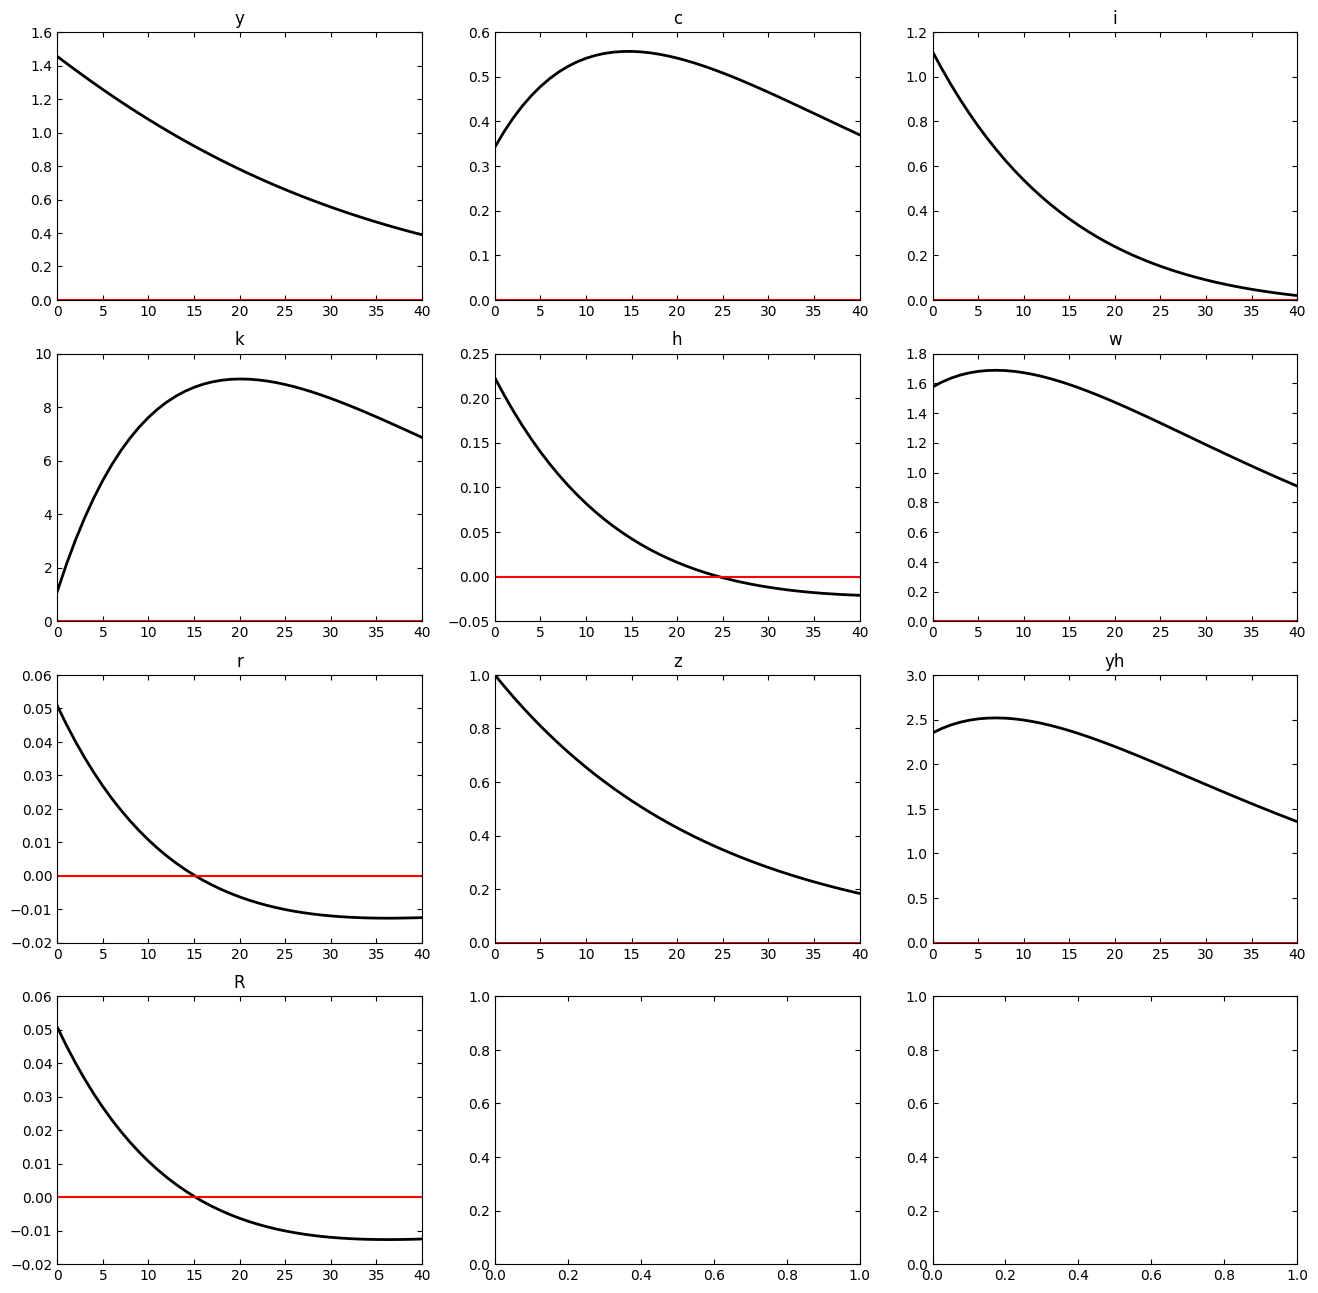

In [36]:
rbc.steady()

rbc.stoch_simul(irf=40)

In [37]:
rbc.SimulatedMoments(hp_filter=1600, shocks_stderr=stderr_z)
# rbc.SimulatedMoments(hp_filter=1600, shocks_stderr=0.008016122502811389)

SIMULATED MOMENTS

VARIABLE 	 STD. DEV.
y 		 1.5257
c 		 0.5283
i 		 5.0237
k 		 0.4324
h 		 0.7022
w 		 0.8431
r 		 5.4215
z 		 1.0469
yh 		 0.8431
R 		 0.0535

COEFFICIENTS OF AUTOCORRELATION
y 		 0.7212
c 		 0.7974
i 		 0.7100
k 		 0.9580
h 		 0.7084
w 		 0.7455
r 		 0.7081
z 		 0.7164
yh 		 0.7455
R 		 0.7090

MATRIX OF CORRELATIONS
Variables 	 y
y 		 1.0000
c 		 0.9179
i 		 0.9884
k 		 0.3606
h 		 0.9796
w 		 0.9861
r 		 0.9553
z 		 0.9988
yh 		 0.9861
R 		 0.9600


In [46]:
print('Standard Deviations')
print(round(hp_cycles.std(),4))

print('')
print('Autocorrelations')
a = list(dta.columns.values[:10])
for i in range(len(a)):
    print(dta.columns.values[i], '  \t\t', round(hp_cycles[dta.columns.values[i]].autocorr(),4))

print('')
print('Correlations')
print(round(hp_cycles.corr(method='pearson'),4))

Standard Deviations
Output           1.6667
Consumption      1.0809
Investment       4.4800
Capital          0.5505
Hours            1.7360
Wages            0.9136
Interest Rate    0.3941
TFP              0.9938
Productivity     1.3049
Price Level      0.8863
dtype: float64

Autocorrelations
Output   		 0.7781
Consumption   		 0.6164
Investment   		 0.8588
Capital   		 0.9651
Hours   		 0.8107
Wages   		 0.6424
Interest Rate   		 0.4153
TFP   		 0.6877
Productivity   		 0.6378
Price Level   		 0.9051

Correlations
               Output  Consumption  Investment  Capital   Hours   Wages  \
Output         1.0000       0.7557      0.7708   0.3629  0.8247 -0.0590   
Consumption    0.7557       1.0000      0.5399   0.3280  0.7291 -0.1250   
Investment     0.7708       0.5399      1.0000   0.2454  0.6070  0.0010   
Capital        0.3629       0.3280      0.2454   1.0000  0.5660  0.0691   
Hours          0.8247       0.7291      0.6070   0.5660  1.0000 -0.2669   
Wages         -0.0590      -0.

## Homework: role of Frisch elasticity

A key parameter that affects how volatile are hours worked over the business cycle is the so called [Frisch elasticity of labor supply](https://en.wikipedia.org/wiki/Frisch_elasticity_of_labor_supply).

It turns out, that our log-log utility function that we have used has a certain Frisch elasticity "baked in". For example, if the average hours worked are 1/3 of total time available, then it necessarily implies that the Frisch elasticity is equal to 2.

We might want to be able to change the value of this parameter. Therefore, we will use a slightly different utility function. The household will then solve the following problem:

\begin{align*}
\max\quad & U_{t}=\mathrm{E}_{t}\left[\sum_{i=0}^{\infty}\beta^{i}\left(\log c_{t+i}-\phi\frac{h_{t+i}^{1+\eta}}{1+\eta}\right)\right]\\
\text{subject to}\quad & c_{t}+a_{t+1}=w_{t}h_{t}+\left(1+r_{t}\right)a_{t}+d_{t}
\end{align*}

where the parameter $\eta$ (`eta`) is the inverse of the Frisch elasticity of labor supply.

**Task 1**: Derive the first order condition of the households and the optimality condition for the consumption-labor choice. Modify accordingly the code below.

In [47]:
rho_z    = 0.9598499596182404
stderr_z = 0.008016122502811389

var = 'y c i k h w r z yh R'
varexo = 'e'

param_values_Frisch = {'alpha':0.33, sy.symbols('beta'):0.99, 'delta':0.025, 'phi':4.5511, 'rho':rho_z, 'eta':0.5}

model_Frisch = ('-1/c + betta/c(+1)*(1+r(+1))',
# Here goes the new consumption-labor choice equation
        '-h^eta+w/phi*c',
         '-y + z*k(-1)^alpha*h^(1-alpha)',
         '-r + alpha*y/k(-1) - delta',
         '-w + (1-alpha)*y/h',
         '-k + i + (1-delta)*k(-1)',
         '-y + c + i',
         '-log(z) + rho*log(z(-1)) + e',
         '-yh + y/h',
         '-R + 1+r')

initval = (1, 0.8, 0.2, 10, 0.33, 2, 0.01, 1, 3, 1.01)

rbc_Frisch = Dynare(var, varexo, param_values_Frisch, model_Frisch, initval)

rbc_Frisch.system

⎡      β⋅(r_{t+1} + 1)     1        ⎤
⎢      ─────────────── - ─────      ⎥
⎢          c_{t+1}       c_{t}      ⎥
⎢                                   ⎥
⎢      1 - α        α               ⎥
⎢ h_{t}     ⋅k_{t-1} ⋅z_{t} - y_{t} ⎥
⎢                                   ⎥
⎢        α⋅y_{t}                    ⎥
⎢        ─────── - δ - r_{t}        ⎥
⎢        k_{t-1}                    ⎥
⎢                                   ⎥
⎢               y_{t}⋅(1 - α)       ⎥
⎢      -w_{t} + ─────────────       ⎥
⎢                   h_{t}           ⎥
⎢                                   ⎥
⎢  i_{t} + k_{t-1}⋅(1 - δ) - k_{t}  ⎥
⎢                                   ⎥
⎢       c_{t} + i_{t} - y_{t}       ⎥
⎢                                   ⎥
⎢e_{t} + ρ⋅log(z_{t-1}) - log(z_{t})⎥
⎢                                   ⎥
⎢                    y_{t}          ⎥
⎢          -yh_{t} + ─────          ⎥
⎢                    h_{t}          ⎥
⎢                                   ⎥
⎣        -R_{t} + r_{t} + 1         ⎦

**Task 2**: Verify that the above model produces exactly the same steady state and very similar simulated moments as the basic RBC model.

In [ ]:
# Your codes go here

**Task 3**: Use the alternative parametrization below. Under the new parametrization, compute the simulated moments of the model and compare the relative standard deviation of hours to output with the results we got for the basic RBC model.

In [ ]:
param_values_Frisch_alt = {'alpha':0.33, sy.symbols('beta'):0.99, 'delta':0.025, 'phi':2.7759, 'rho':rho_z, 'eta':0.05}

# Your codes go here